# Time Series Bitmaps: a Practical Visualization Tool for Working with Large Time Series Databases

Implementation of the work in Kumar et. al. (2005) for a bitmap representation of time series. The idea is to discretize a time series with the SAX representation using an alphabet of size 4, and generate bitmaps based on the frequency of occurence of patterns. 
Using a generalized suffix tree, we can easily access all subsequence in the discretized time series
and construct multi-level bitmaps (up to 'Level w' precision, w being the word length).

_Inputs:_
- _D = Database of time series_
- _w = word length_

## Basic Functions

In [158]:
from string import ascii_lowercase
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns
import numpy as np

def make_sentence(letter_list): 
    """
    Converts a list of strings into a string i.e. ['a', 'b', 'c'] --> 'abc'
    """
    return ''.join(l for l in letter_list)

def plot_bitmaps(bitmaps, lettermaps, level):
    """
    Simple plot function.
    """
    
    f, axes = plt.subplots(len(bitmaps), 1, figsize=(8, len(bitmaps)*8))
    
    for i, (bitmap, lettermap, ax) in enumerate(zip(bitmaps, lettermaps, axes)):
        
        sns.heatmap(bitmap/np.amax(bitmap), annot=lettermap, fmt='', square=True, 
                    cmap=sns.cubehelix_palette(start=0, rot=-0.1, as_cmap=True),
                    cbar_kws={'shrink': 0.5}, 
                    annot_kws={"size": 20-3*level},
                    ax=ax)
        ax.set_title(f'Time Series {i} - Level {level}')
        ax.tick_params(axis='both', left=False, bottom=False, labelleft=False, labelbottom=False)
    
    plt.tight_layout()
    plt.show()
    
    return

## Suffix Tree

In [55]:
from suffix_tree import Tree

def make_tree(S):
    """
    Constructs a suffix tree from a list of strings
    """
    return Tree({1: make_sentence(S)}) 

def bitmap_trees(D):
    """
    Constructs a list of suffix trees from the different time series in the database. 
    One time series = one tree.
    """
    return [make_tree(S) for S in D]

def find_motifs(tree, motif):
    """
    Finds the number of times a motif is repeated in a tree. 
    Returns the counts and the offset of the matches.
    """
    return tree.find_all(motif)

## SAX Representation

### Normalization

In [13]:
def zscore_norm(S):
    """
    z-normalization of a unidimensional time series. 
    Returns (value-mean)/std.
    """    
    
    if np.std(S) < 0.01:
        return S-np.mean(S)
    
    return (S-np.mean(S))/np.std(S)

### PAA

In [ ]:
def paa(S_norm, w):
    """
    Piecewise Aggregate Approximation (PAA) of a unidimensional time series (Keogh et. al. (2001)).
    S_norm is a normalized time series as a numpy array.
    w is the number of segments.
    """
    
    n = len(S_norm)
    S_paa = np.zeros(w)
        
    if n % w == 0:
        # Each segment will automatically have the same number of points
        l = n // w # Segment length
        for i in range(w):
            S_paa[i] = np.mean(S_norm[i*l:(i+1)*l])
            
    else:
        # We have to make sure that each segment gets an equal number of points
        points_per_seg = np.zeros(w)
        i_last_val = None
        i_last_segment = None
        
        for i in range(n*w):
            i_segment = i // n
            i_val = i // w            
            S_paa[i_segment] += S_norm[i_val]
            
            # Check that everything is fine 
            # print(f'n={n}, w={w}, i={i}, i_segment={i_segment}, i_val={i_val}')
            
        S_paa /= n

    return S_paa

### Discretization

In [ ]:
def lookup_table(a):
    
    alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
    table = {
        2: np.array([-np.inf,  0.00]),
        3: np.array([-np.inf, -0.43072, 0.43072]),
        4: np.array([-np.inf, -0.67448, 0, 0.67448]),
        5: np.array([-np.inf, -0.84162, -0.25334, 0.25334, 0.84162]),
        6: np.array([-np.inf, -0.96742, -0.43072, 0, 0.43072, 0.96742]),
        7: np.array([-np.inf, -1.06757, -0.56594, -0.18001, 0.18001, 0.56594, 1.06757]),
        8: np.array([-np.inf, -1.15034, -0.67448, -0.31863, 0, 0.31863, 0.67448, 1.15034]),
        9: np.array([-np.inf, -1.22064, -0.76470, -0.43072, -0.13971, 0.13971, 0.43072, 0.76470, 1.22064]),
        10: np.array([-np.inf, -1.28155, -0.84162, -0.52440, -0.25334, 0, 0.25334, 0.52440, 0.84162, 1.28155])
    }
    
    return table[a], alphabet[:a+1]

def discretization(S_paa, a):
    
    breakpoints, alphabet = lookup_table(a)
    S_discrete = []
    
    for val in S_paa:
        S_discrete.append(alphabet[np.where(breakpoints<val)[0][-1]])
    
    return S_discrete, breakpoints

## Time Series Bitmaps

In [151]:
def find_pos(pattern, n_quarter, pos):
    """
    Solve the (i, j) position of the motif in the bitmap by reccurence.
    """
    
    # Initialiation    
    pos_values = {
        'a': np.array([0, 0]),
        'b': np.array([0, 1]),
        'c': np.array([1, 0]),
        'd': np.array([1, 1])
    }
    
    # Recurrence
    if len(pattern) > 0:
        pos += n_quarter * pos_values[pattern[0]]
        return find_pos(pattern[1:], n_quarter=n_quarter//2, pos=pos)
        
    # Termination
    else:
        return pos.astype(int)

def bitmap_computation(trees, level):
    """
    Computes bitmaps for all suffix tree representations of the time series in the 
    database D, at the 'level' precision.
    """ 
    
    # Initialization
    bitmaps = []
    lettermaps = []
    
    # Generate all possible subpatterns using an alphabet of size a=4
    alphabet = ascii_lowercase[:4]
    patterns = [''.join(i) for i in product(alphabet, repeat=level)]
    
    # For each tree in the list
    for tree in trees:
        
        # Initialize bitmap with zeros 
        size = 4**level
        N = int(size**0.5)
        bitmap = np.zeros((N, N))
        lettermap = np.zeros((N, N), dtype=object)
        
        # Loop over all potential patterns
        for i_pattern, p in enumerate(patterns):

            # Count the number of times this pattern appears in the tree 
            freq, _ = find_motifs(tree, motif=p)
            
            # Update the bitmap with the count, at the right position
            pos = find_pos(p, n_quarter=N//2, pos=np.zeros(2)) 
            bitmap[pos[0], pos[1]] += freq
            lettermap[pos[0], pos[1]] = p
            
        bitmaps.append(bitmap)
        lettermaps.append(lettermap)
        
    return bitmaps, lettermaps

## Tests

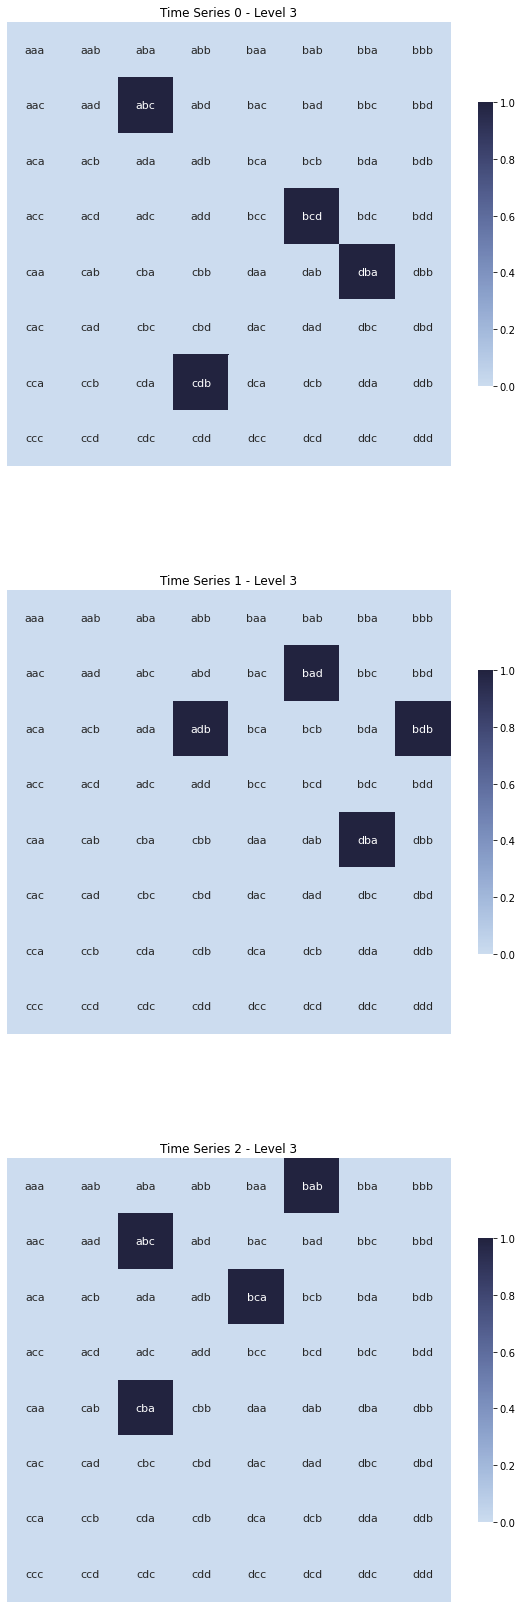

In [162]:
D = [['a', 'b', 'c', 'd', 'b', 'a'], 
     ['b', 'd', 'b', 'a', 'd', 'b'], 
     ['c', 'b', 'a', 'b', 'c', 'a']]

# Bitmap parameter
level = 3

# Computations
trees = bitmap_trees(D)
bitmaps, lettermaps = bitmap_computation(trees, level)

# Plot
plot_bitmaps(bitmaps, lettermaps, level)